## Cargar datos de entrenamiento

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

bright_path = '/kaggle/input/sperm3d-centerlinefromfocalplane/bright_field'
hue_path    = '/kaggle/input/sperm3d-centerlinefromfocalplane/hue_stack'
centerline_path    = '/kaggle/input/sperm3d-centerlinefromfocalplane/centerline_map'

#bright_path = '/kaggle/input/sperm2dto3d/bright_field'
#hue_path    = '/kaggle/input/sperm2dto3d/hue_stack'
#centerline_path    = '/kaggle/input/sperm2dto3d/centerline_map'

image_name = sorted(os.listdir(bright_path))

# Splitting the data into train and test sets
train_test_split = 1024+256  # Adjust this as needed
train_name_1 = image_name[:train_test_split]

train_valid_split = 1024
train_name= train_name_1[:train_valid_split]
valid_name = train_name_1[train_valid_split:]

# Construir generadores para el entrenamiento

In [2]:
from skimage import io

def data_generator_seg(filenames, batch_size):
    num_samples = len(filenames)
    while True:
        # Shuffle the indices at the start of each epoch
        indices = np.random.permutation(num_samples)
        
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            #batch_file_pairs = [file_pairs[j] for j in batch_indices]
            batch_inputs = [io.imread(os.path.join(hue_path       , filenames[j])) for j in batch_indices]
            batch_outputs= [io.imread(os.path.join(centerline_path, filenames[j])) for j in batch_indices]
            #
            inputs = np.array(batch_inputs)/255
            outputs = np.ceil(np.array(batch_outputs)/255)
            if len(inputs.shape) == 3:
                inputs = np.expand_dims(inputs, axis=-1)  # [B,H,W] -> [B,H,W,1]
            if len(outputs.shape) == 3:
                outputs = np.expand_dims(outputs, axis=-1)
            yield inputs, outputs
            #yield np.array(batch_inputs)/255,np.array(batch_inputs)/255
            

batch_size = 32
train_generator = data_generator_seg(train_name, batch_size)
validation_generator = data_generator_seg(valid_name, batch_size)

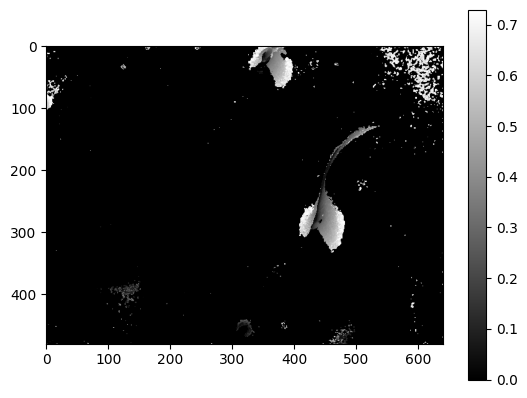

In [7]:

c=plt.imshow(tr[0][0],cmap="gray")
plt.colorbar(c)
plt.show()

In [11]:
print(np.max(tr[1][0]))

1.0


# Construir unet

In [8]:
import tensorflow as tf
from tensorflow import keras
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.layers import multiply, add, Activation, BatchNormalization,LeakyReLU, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K

def attention_gate(inp_1, inp_2, n_intermediate_channels):
    inp_1_conv = Conv2D(n_intermediate_channels, (1, 1), padding='same')(inp_1)
    inp_2_conv = Conv2D(n_intermediate_channels, (1, 1), padding='same')(inp_2)
    f = add([inp_1_conv, inp_2_conv])
    f = Activation('relu')(f)
    gate = Conv2D(1, (1, 1), padding='same', activation="sigmoid")(f)
    return multiply([inp_2, gate])

def conv_block(input_tensor, num_filters):
    encoder = Conv2D(num_filters, (3, 3), padding='same', activation=LeakyReLU(0.3),kernel_initializer="HeNormal")(input_tensor)
    encoder = BatchNormalization()(encoder)
    encoder = Conv2D(num_filters, (3, 3), padding='same', activation=LeakyReLU(0.3),kernel_initializer="HeNormal")(encoder)
    encoder = BatchNormalization()(encoder)
    return encoder

def r2_conv_block(input_tensor, num_filters, t=2):
    x = input_tensor
    for _ in range(t):
        x1 = Conv2D(num_filters, (3, 3), padding='same', activation=LeakyReLU(0.3),kernel_initializer="HeNormal")(x)
        x1 = BatchNormalization()(x1)
        x = add([x, x1])
    return x

def encoder_block(input_tensor, num_filters, dropout_rate=0.2):
    encoder = conv_block(input_tensor, num_filters)
    encoder = Dropout(dropout_rate)(encoder)
    encoder_pool = MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = concatenate([decoder, concat_tensor], axis=-1)
    decoder = conv_block(decoder, num_filters)
    return decoder

def decoder_block_r2(input_tensor, concat_tensor, num_filters):
    decoder = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = concatenate([decoder, concat_tensor], axis=-1)
    decoder = r2_conv_block(decoder, num_filters)
    return decoder

def get_attention_unet(input_shape, num_filters_start=16):
    inputs = Input(input_shape)
    encoder_pool0, encoder0 = encoder_block(inputs, num_filters_start)
    encoder_pool1, encoder1 = encoder_block(encoder_pool0, num_filters_start*2)
    center = conv_block(encoder_pool1, num_filters_start*4)
    decoder1 = decoder_block(center, encoder1, num_filters_start*2)
    attn1 = attention_gate(encoder1, decoder1, num_filters_start*2)
    decoder0 = decoder_block(attn1, encoder0, num_filters_start)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(decoder0)
    model = Model(inputs=[inputs], outputs=[outputs],name="Att-U-Net")
    return model

def get_deep_attention_unet(input_shape, num_filters_start=16):
    """Enhanced Attention U-Net with 2 additional depth layers"""
    inputs = Input(input_shape)
    
    # Encoder Path (4 levels now)
    encoder_pool0, encoder0 = encoder_block(inputs, num_filters_start)         # Level 1
    encoder_pool1, encoder1 = encoder_block(encoder_pool0, num_filters_start*2) # Level 2
    encoder_pool2, encoder2 = encoder_block(encoder_pool1, num_filters_start*4) # New Level 3
    encoder_pool3, encoder3 = encoder_block(encoder_pool2, num_filters_start*8) # New Level 4
    
    # Center
    center = conv_block(encoder_pool3, num_filters_start*16)                   # Deeper center
    
    # Decoder Path with Attention Gates
    decoder3 = decoder_block(center, encoder3, num_filters_start*8)            # New Level 4
    attn3 = attention_gate(encoder3, decoder3, num_filters_start*8)
    
    decoder2 = decoder_block(attn3, encoder2, num_filters_start*4)             # New Level 3
    attn2 = attention_gate(encoder2, decoder2, num_filters_start*4)
    
    decoder1 = decoder_block(attn2, encoder1, num_filters_start*2)             # Level 2
    attn1 = attention_gate(encoder1, decoder1, num_filters_start*2)
    
    decoder0 = decoder_block(attn1, encoder0, num_filters_start)               # Level 1
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(decoder0)
    
    model = Model(inputs=[inputs], outputs=[outputs], name="Deep-Att-U-Net")
    return model

def get_simple_unet(input_shape, num_filters_start=16):
    inputs = Input(input_shape)
    encoder_pool0, encoder0 = encoder_block(inputs, num_filters_start)
    encoder_pool1, encoder1 = encoder_block(encoder_pool0, num_filters_start * 2)
    center = conv_block(encoder_pool1, num_filters_start * 4)
    decoder1 = decoder_block(center, encoder1, num_filters_start * 2)
    decoder0 = decoder_block(decoder1, encoder0, num_filters_start)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(decoder0)
    model = Model(inputs=[inputs], outputs=[outputs],name="U-Net")
    return model

def get_attention_r2_unet(input_shape, num_filters_start=16):
    inputs = Input(input_shape)
    encoder_pool0, encoder0 = encoder_block(inputs, num_filters_start)
    encoder_pool1, encoder1 = encoder_block(encoder_pool0, num_filters_start*2)
    #center = r2_conv_block(encoder_pool1, num_filters_start*4)
    center = conv_block(encoder_pool1, num_filters_start * 4)
    
    decoder1 = decoder_block_r2(center, encoder1, num_filters_start*2)
    attn1 = attention_gate(encoder1, decoder1, num_filters_start*2)
    decoder0 = decoder_block_r2(attn1, encoder0, num_filters_start)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(decoder0)
    #model = Model(inputs=[inputs], outputs=[outputs],name="Att-r2-U-Net")
    model =Model()
    return model



def weighted_bce(ground_truth,y_pred):
    ground_truth = tf.cast(ground_truth,float)
    weights =  ground_truth * 75 + 1.
    bce = K.binary_crossentropy(ground_truth, y_pred)
    weighted_bce = K.mean(bce * weights)
    return weighted_bce

checkpoint_filepath = 'unet2-5.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',  # Change to 'val_loss' to monitor weighted BCE loss
    mode='min',  # Change to 'min' since we are monitoring loss
    save_best_only=True
)


def weighted_mae(y_true, y_pred):
    """
    MAE where non-zero pixels are weighted by 1000, zeros (background) by 1.
    """
    weights = tf.where(tf.not_equal(y_true, 0), 50.0, 1.0)
    error = tf.abs(y_true - y_pred)
    weighted_error = weights * error
    return tf.reduce_mean(weighted_error)


unet_model = get_attention_unet(input_shape = (480, 640, 1), num_filters_start=16)
unet_model.summary()




2025-04-24 03:51:12.734964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745466672.923578      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745466672.976974      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1745466685.101197      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "Att-U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 480, 640, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 480, 640, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 480, 640, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 480, 640, 16)   │          2,320 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 480, 640, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 480, 640, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 240, 320, 16)   │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 240, 320, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 240, 320, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 240, 320, 32)   │          9,248 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 240, 320, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 240, 320, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 120, 160, 32)   │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 120, 160, 64)   │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 120, 160, 64)   │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 120, 160, 64)   │         36,928 │ batch_normalization_4… │
├──────────────────────

 Total params: 120,178 (469.45 KB)

 Trainable params: 119,538 (466.95 KB)

 Non-trainable params: 640 (2.50 KB)

In [10]:
# Start the timer
import time
import tensorflow.keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau




def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def iou_loss(y_true, y_pred):
    # Using Jaccard/IoU directly as loss (to maximize)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return 1 - (intersection + 1e-7) / (union + 1e-7)  # Minimize 1-IoU


unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Reducir LR
    loss=iou_loss,  # Parámetros típicos para desbalance
    metrics=[tf.keras.metrics.binary_focal_crossentropy,"bce","mae"]  # Métrica personalizada
)
# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='loss',  # Monitor validation loss
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best-performing model
)


# Define the ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='loss',
    factor=0.1,  # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1  # Print a message when the learning rate is reduced
)

start_time = time.time()

# Train the model
history=unet_model.fit(
    train_generator,
    steps_per_epoch=int(np.floor(len(train_name) / batch_size)),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=int(np.floor(len(valid_name) / batch_size)),
    callbacks=[model_checkpoint_callback,early_stopping_callback]#,reduce_lr_callback]
)

# Calculate the training time
training_time = time.time() - start_time

# Print the training time
print("Training time:", training_time/60, "min")

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 741ms/step - bce: 0.9708 - binary_focal_crossentropy: 0.6198 - loss: 0.9920 - mae: 0.3750 - val_bce: 0.2273 - val_binary_focal_crossentropy: 0.0602 - val_loss: 0.9890 - val_mae: 0.1698
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 598ms/step - bce: 1.6647 - binary_focal_crossentropy: 1.5573 - loss: 0.9852 - mae: 0.1980 - val_bce: 0.2328 - val_binary_focal_crossentropy: 0.1537 - val_loss: 0.9826 - val_mae: 0.0905
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 576ms/step - bce: 1.7415 - binary_focal_crossentropy: 1.6696 - loss: 0.9800 - mae: 0.1452 - val_bce: 0.2609 - val_binary_focal_crossentropy: 0.2073 - val_loss: 0.9847 - val_mae: 0.0637
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 576ms/step - bce: 1.6871 - binary_focal_crossentropy: 1.6365 - loss: 0.9722 - mae: 0.1033 - val_bce: 1.2980 - val_binary_focal_crossentropy: 1.2389 - val_loss: 0.9692 - val_mae: 0.0776
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 587ms/step - bce: 1.5344 - binary_focal_crossentro

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


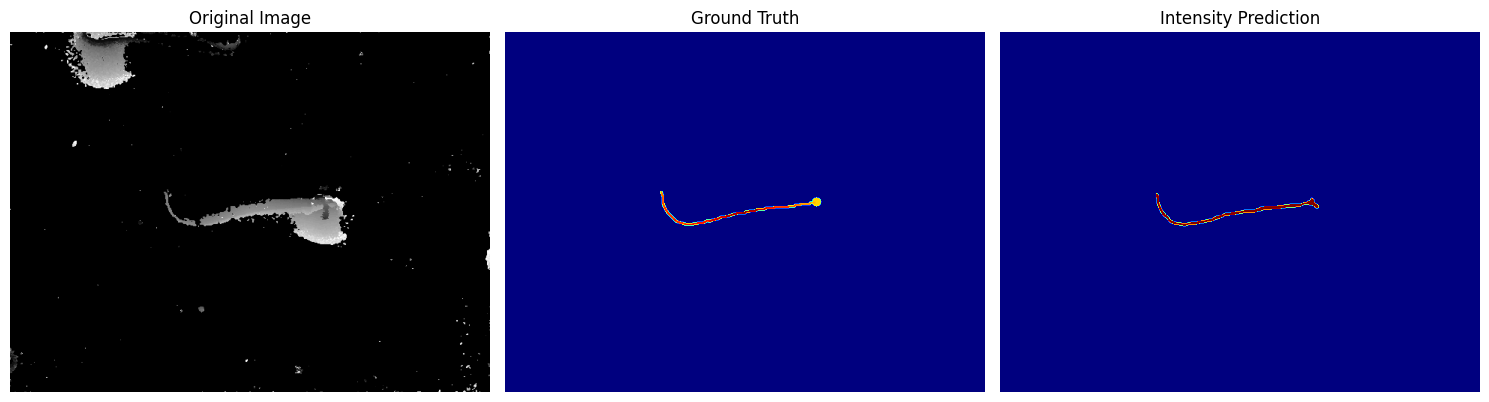

In [11]:

# Load your single image
source_img = io.imread(os.path.join(hue_path, image_name[20]))/255
target_img = io.imread(os.path.join(centerline_path, image_name[20]))/255


#source_img = io.imread(os.path.join(bright_path, image_name[200]))/255
#target_img = io.imread(os.path.join(centerline_path, image_name[200]))/255
#if len(source_img.shape) == 2:
#    source_img = source_img[..., np.newaxis]


# Create a batch
batch_x = np.array([source_img], dtype=np.float32)
batch_y = np.array([target_img], dtype=np.float32)


# Preprocess the input image and ground truth mask


# Generate prediction
prediction = unet_model.predict(batch_x)

# Expand dimensions for prediction

# Plot the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
axs[0].imshow(batch_x[0], cmap="gray")
axs[0].set_title("Original Image")
#plt.colorbar(plt.cm.ScalarMappable(cmap="gray"), ax=axs[0], orientation='vertical')
axs[0].axis("off")

# Ground Truth
axs[1].imshow(batch_y[0], cmap="jet")
axs[1].set_title("Ground Truth")
#plt.colorbar(plt.cm.ScalarMappable(cmap="gray"), ax=axs[1], orientation='vertical')

axs[1].axis("off")

# Prediction
#print(prediction[0])
pred=prediction[0][5]=0
axs[2].imshow(prediction[0], cmap="jet")
axs[2].set_title("Intensity Prediction")
#plt.colorbar(plt.cm.ScalarMappable(cmap="gray"), ax=axs[2], orientation='vertical')
axs[2].axis("off")
#print(prediction[0])

plt.tight_layout()
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_overlay(original_image, attention_map):
    #attention_resized = tf.image.resize(attention_map, size=(original_image.shape[0], original_image.shape[1]))
    #attention_resized = tf.squeeze(attention_resized).numpy()

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title('Original Image')

    plt.subplot(1,2,2)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.imshow(attention_map[-1], cmap='jet', alpha=0.4)  # Overlay transparente
    plt.title('Attention Overlay')
    plt.show()


In [ ]:
attention_maps = attention_extractor.predict(batch_x)
plot_attention_overlay(batch_x[0], attention_maps[0][0])  # Primera atención


In [12]:
import pandas as pd

# Convert to DataFrame
history_df = pd.DataFrame(history.history)

# Show the first few rows
print(history_df.head())

history_df.to_csv('training_history.csv', index=False)

        bce  binary_focal_crossentropy      loss       mae   val_bce  \
0  1.185199                   0.923493  0.990148  0.311370  0.227256   
1  1.702636                   1.606537  0.984180  0.184561  0.232757   
2  1.726750                   1.659451  0.978512  0.135262  0.260895   
3  1.652679                   1.605998  0.969710  0.094303  1.297999   
4  1.487426                   1.457540  0.953322  0.059698  0.890478   

   val_binary_focal_crossentropy  val_loss   val_mae  
0                       0.060213  0.989017  0.169775  
1                       0.153679  0.982551  0.090506  
2                       0.207252  0.984702  0.063662  
3                       1.238883  0.969165  0.077596  
4                       0.856247  0.950406  0.051724  


In [ ]:
# Optionally, save the metrics DataFrame to a CSV file
metrics_df.to_csv('training_metrics.csv', index=False)
metrics_df